# Support points with Exponential Mechanism + Grid-Walk

___

In [1]:
%matplotlib inline

import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pdb
from scipy.spatial.distance import pdist
import sys
import tensorflow as tf
import time

from data import load_balog_data
from sp_utils import (
    get_support_points,
    get_energy_sensitivity,
    sample_sp_exp_mech,
    sample_sp_exp_mech_gridwalk)

matplotlib.rcParams.update({'font.size': 14})
plt.style.use('ggplot')
print(sys.version)
print(tf.__version__)

3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
1.13.1


____

# 1. Global Config

Note: Exponential samples (i.e. energy distances) are smaller with:
  - large privacy budget, $\alpha$
  - small sensitivity, $\Delta f$
  - small dimensionality, $d$
  - large energy exponent, $p$
  - large support point set, $N$

In [2]:
# Set global constants.          # main1()
IS_TF = True                     # Boolean. Use TensorFlow rather than analytical gradients.
Y_INIT_OPTION = 'random'         # ['grid', 'random', 'radial']
MAX_ITER = 301                   # Num iterations in each support point optimization. [301]
LR = 1e-2                        # Energy optimization learning rate. [1e-2]

NUM_DATA = 200                   # Number of data points. [200]
DIM = 2                          # Dimension of data. [2]
C = 10                           # Number of clusters in data. [10]
SIGMA_DATA = 0.03                # Bandwidth of data. [0.03]

NUM_SUPP = 10                    # Number of support points. [10]
ENERGY_POWER = 2                # Power for energy distance kernel. [2]

___

# 2. Load Data

In [3]:
# Load data.
np.random.seed(123)
x = load_balog_data(NUM_DATA, DIM, C, SIGMA_DATA, make_new=True, do_weighted=True)
#x = np.load('../../RKHS-private-database/data/mixture_of_Gaussians_N1000_D2_C10_SIG0.03.npz')['X_private']
print(x.shape)

Loaded M=200, DIM=2, SIG=0.03, C=10
(200, 2)


___

# 3. Run Support Point Optimization


STARTING RUN. is_tf: True, y_init: random, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
  [*] Overall it/s: 0.0062


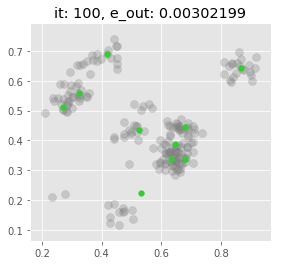

  [*] Overall it/s: 0.0064


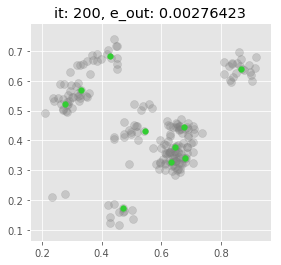

  [*] Overall it/s: 0.0062


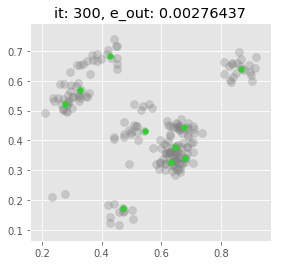

  [*] Time elapsed: 2.06


In [4]:
# Compute m support points on full set.
y_opt, e_opt = get_support_points(x, NUM_SUPP, MAX_ITER, LR, is_tf=IS_TF,
                                  power=ENERGY_POWER, y_init_option=Y_INIT_OPTION)  # NOTE: Power=2 to derive optimal SP.

___

## 4. Sample support points with Exponential Mechanism + Grid-Walk

Num steps for (100, 0.1)-approxDP = 33183866236


/home/maurice/privacy/mv_sp_privacy/src/sp_utils.py:436: RuntimeWarning: divide by zero encountered in power
  term1 = c1 * np.sum(pairwise_difs ** power, axis=2) ** (c1 - 1)


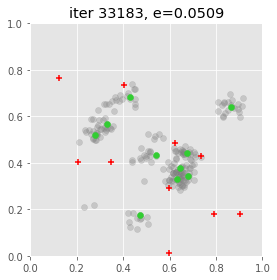

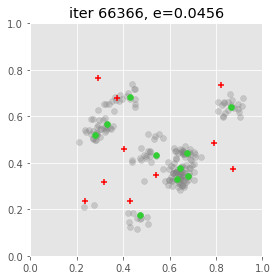

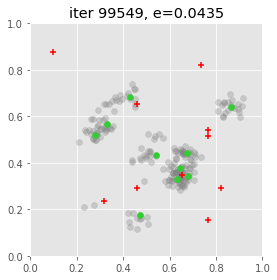

/home/maurice/virtualenvironment/py3.5/lib/python3.5/site-packages/matplotlib/axis.py:1091: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


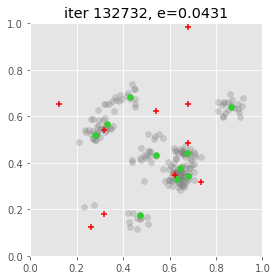

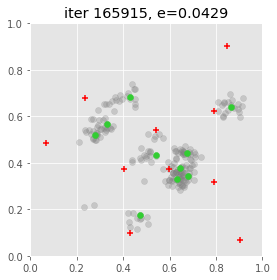

KeyboardInterrupt: 

In [5]:
ALPHA = 100
energy_sensitivity = get_energy_sensitivity(x, NUM_SUPP, power=ENERGY_POWER)

y_t, energy_t = sample_sp_exp_mech_gridwalk(
    energy_sensitivity, y_opt, x, alpha=ALPHA, power=ENERGY_POWER)

In [ ]:
plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3,
                        label='data')
plt.scatter(y_opt[:, 0], y_opt[:, 1], c='limegreen',
            label='sp(data)')
plt.scatter(y_t[:, 0], y_t[:, 1], c='red', alpha=1,
            label='~sp(data)', marker='+')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('iter {}, alpha={}, e={:.4f}'.format(i, ALPHA, energy_t))
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig('../output/priv_sp_sample_gridwalk.png')
plt.show()
plt.close()

In [ ]:
# Still have the rejection sampling step...